In [1]:
# GoogleFinance
# Data Clean up
# Health Care Monte Carlo
# Industrials Monte Carlo
# Utilities Monte Carlo

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os 
import seaborn as sns
from dotenv import load_dotenv

%matplotlib inline

In [3]:
#Try ALPACA data retrieval next
load_dotenv()

Api_key = os.getenv("Api_key")
Secret_key = os.getenv("Secret_key")

api = tradeapi.REST(Api_key, Secret_key, api_version='v2')

type(Api_key)

str

In [4]:
#Use alpha vantage to get historic quotes for XLV, XLI, XLU. This goes back 20 years.

health_df = api.alpha_vantage.historic_quotes('XLV', adjusted=True, output_format='pandas')
health_df.head()

industrial_df = api.alpha_vantage.historic_quotes('XLI', adjusted=True, output_format='pandas')
# industrial_df.tail()

utilities_df = api.alpha_vantage.historic_quotes('XLU', adjusted=True, output_format='pandas')
# utilities_df.head()
sp500_df = api.alpha_vantage.historic_quotes('SPY', adjusted=True, output_format='pandas')

In [5]:
sp500_df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-05-01,285.31,290.6572,281.52,282.79,282.79,125045778.0,0.0,1.0
2020-04-30,291.71,293.3239,288.59,290.48,290.48,121537052.0,0.0,1.0
2020-04-29,291.53,294.8800,290.41,293.21,293.21,118066585.0,0.0,1.0
2020-04-28,291.02,291.4000,285.40,285.73,285.73,104797847.0,0.0,1.0
2020-04-27,285.12,288.2700,284.62,287.05,287.05,77516422.0,0.0,1.0


In [6]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

health_df = health_df['5. adjusted close']
health_df.head()

industrial_df = industrial_df['5. adjusted close']
industrial_df.head()

utilities_df = utilities_df['5. adjusted close']
utilities_df.head()

sp500_df = sp500_df['5. adjusted close']
sp500_df.head()

#Use concat to put the data in one dataframe
concat_df = pd.concat([health_df, industrial_df, utilities_df, sp500_df], axis = "columns", join = "inner")
concat_df.head()

,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close
date,,,,
2020-05-01,97.83,62.27,55.88,282.79
2020-04-30,99.73,64.21,57.26,290.48
2020-04-29,100.19,65.51,58.61,293.21
2020-04-28,99.53,64.28,59.15,285.73
2020-04-27,101.58,63.10,58.93,287.05


In [7]:
#Change column names to avoid confusion
columns = ['HealthCare_close', 'Industrials_close', 'Utilities_close', 'SP500_close']
concat_df.columns = columns
concat_df.head()

,HealthCare_close,Industrials_close,Utilities_close,SP500_close
date,,,,
2020-05-01,97.83,62.27,55.88,282.79
2020-04-30,99.73,64.21,57.26,290.48
2020-04-29,100.19,65.51,58.61,293.21
2020-04-28,99.53,64.28,59.15,285.73
2020-04-27,101.58,63.10,58.93,287.05


In [8]:
#Sort earliest to latest so that .pct_change() function works right.

concat_df.sort_index(inplace=True, ascending=True)
concat_df.head()

,HealthCare_close,Industrials_close,Utilities_close,SP500_close
date,,,,
2000-05-01,22.5431,20.6869,13.7361,100.7139
2000-05-02,22.0909,20.4753,13.2393,98.7022
2000-05-03,21.4756,19.7928,13.2875,96.3909
2000-05-04,21.4089,19.8269,13.2634,97.1185
2000-05-05,21.3792,20.1750,13.2923,98.2956


In [9]:
returns_df = concat_df.pct_change()
returns_df

,HealthCare_close,Industrials_close,Utilities_close,SP500_close
date,,,,
2000-05-01,NaN,NaN,NaN,NaN
2000-05-02,-0.020059,-0.010229,-0.036167,-0.019974
2000-05-03,-0.027853,-0.033333,0.003641,-0.023417
2000-05-04,-0.003106,0.001723,-0.001814,0.007548
2000-05-05,-0.001387,0.017557,0.002179,0.012120
...,...,...,...,...
2020-04-27,0.012863,0.024850,0.010460,0.014418
2020-04-28,-0.020181,0.018700,0.003733,-0.004599
2020-04-29,0.006631,0.019135,-0.009129,0.026179


In [10]:
# Drop nulls
returns_df.dropna(inplace=True)

#count nulls again
returns_df.isnull().sum()

HealthCare_close     0
Industrials_close    0
Utilities_close      0
SP500_close          0
dtype: int64

In [11]:
# Checking for duplicate rows
returns_df.duplicated()

date
2000-05-02    False
2000-05-03    False
2000-05-04    False
2000-05-05    False
2000-05-08    False
              ...  
2020-04-27    False
2020-04-28    False
2020-04-29    False
2020-04-30    False
2020-05-01    False
Length: 5032, dtype: bool

In [12]:
# drop duplicates
returns_df.drop_duplicates(inplace=True)
returns_df.head()

,HealthCare_close,Industrials_close,Utilities_close,SP500_close
date,,,,
2000-05-02,-0.020059,-0.010229,-0.036167,-0.019974
2000-05-03,-0.027853,-0.033333,0.003641,-0.023417
2000-05-04,-0.003106,0.001723,-0.001814,0.007548
2000-05-05,-0.001387,0.017557,0.002179,0.012120
2000-05-08,0.002428,-0.000337,0.006899,-0.007512


In [13]:
# drop close columns to create dataframe for daily returns
returns_df.rename(columns={'HealthCare_close': 'HealthCare_return',
                           'Industrials_close': 'Industrials_return',
                           'Utilities_close': 'Utilities_return',
                           'SP500_close': 'SP500_return'},
                  inplace=True)
returns_df.head()

,HealthCare_return,Industrials_return,Utilities_return,SP500_return
date,,,,
2000-05-02,-0.020059,-0.010229,-0.036167,-0.019974
2000-05-03,-0.027853,-0.033333,0.003641,-0.023417
2000-05-04,-0.003106,0.001723,-0.001814,0.007548
2000-05-05,-0.001387,0.017557,0.002179,0.012120
2000-05-08,0.002428,-0.000337,0.006899,-0.007512


In [14]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_health = (1 + returns_df['HealthCare_return']).cumprod()
cumulative_returns_industrial = (1 + returns_df['Industrials_return']).cumprod()
cumulative_returns_utilities = (1 + returns_df['Utilities_return']).cumprod()
cumulative_returns_sp500 = (1 + returns_df['SP500_return']).cumprod()

In [15]:
cumulative_returns_health.head()

date
2000-05-02    0.979941
2000-05-03    0.952646
2000-05-04    0.949687
2000-05-05    0.948370
2000-05-08    0.950672
Name: HealthCare_return, dtype: float64

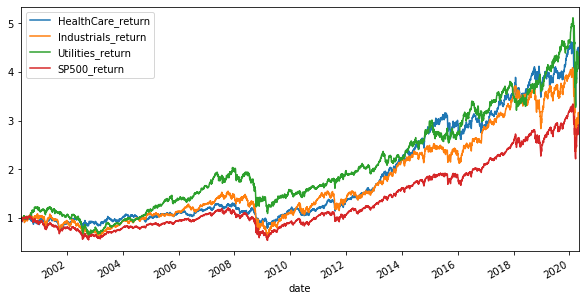

In [16]:
#plot cumulative returns

cumulative_returns_health.plot(figsize=(10,5), legend=True)
cumulative_returns_industrial.plot(figsize=(10,5), legend=True)
cumulative_returns_utilities.plot(figsize=(10,5), legend=True)
cumulative_returns_sp500.plot(figsize=(10,5), legend=True)

In [17]:
# Calculate Standard Deviations for each sector
HealthCare_std = returns_df['HealthCare_return'].std()
print(f' Healthcare standard deviation is {HealthCare_std}')


Industrials_std = returns_df['Industrials_return'].std()
print(f' Industrials standard deviation is {Industrials_std}')

Utilities_std = returns_df['Utilities_return'].std()
print(f' Utilities standard deviation is {Utilities_std}')

SP500_std = returns_df['SP500_return'].std()
print(f' S&P 500 standard deviation is {SP500_std}')


# Identify the sector with highest standard deviation (riskiest)
sectors = [HealthCare_std, Industrials_std, Utilities_std, SP500_std]
print(sectors)

 Healthcare standard deviation is 0.011688454892380776
 Industrials standard deviation is 0.013765560431991487
 Utilities standard deviation is 0.012419046742428814
 S&P 500 standard deviation is 0.012436030200556558
[0.011688454892380776, 0.013765560431991487, 0.012419046742428814, 0.012436030200556558]


In [18]:
# Calculate the annualized standard deviation (252 trading days) for each sector
annual_HealthCare_std = HealthCare_std * np.sqrt(252)
annual_HealthCare_std

annual_Industrials_std = Industrials_std * np.sqrt(252)
annual_Industrials_std

annual_Utilities_std = Utilities_std * np.sqrt(252)
annual_Utilities_std

annual_SP500_std = SP500_std * np.sqrt(252)
annual_HealthCare_std

0.1855484691350146

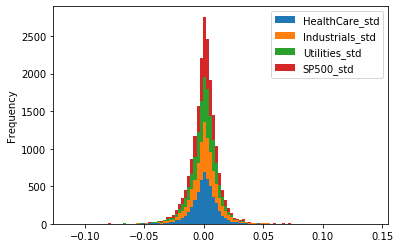

In [19]:
#Plot

sectors_std = pd.DataFrame({
    "HealthCare_std": returns_df['HealthCare_return'],
    "Industrials_std": returns_df['Industrials_return'],
    "Utilities_std": returns_df['Utilities_return'],
    "SP500_std": returns_df['SP500_return']
})

sectors_std.plot.hist(stacked=True, bins=100)

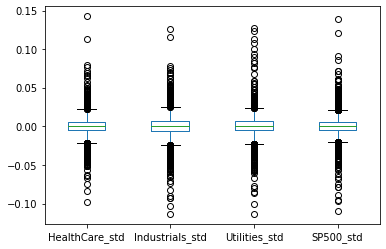

In [20]:
sectors_std.plot.box()

In [21]:
# Calculate Sharpe Ratios for the sectors

HealthCare_sharpe = (returns_df['HealthCare_return'].mean() * 252) / (returns_df['HealthCare_return'].std() * np.sqrt(252))

Industrials_sharpe = (returns_df['Industrials_return'].mean() * 252) / (returns_df['Industrials_return'].std() * np.sqrt(252))

Utilities_sharpe = (returns_df['Utilities_return'].mean() * 252) / (returns_df['Utilities_return'].std() * np.sqrt(252))

SP500_sharpe = (returns_df['SP500_return'].mean() * 252) / (returns_df['SP500_return'].std() * np.sqrt(252))

print(f" HealthCare: {HealthCare_sharpe}, Industrials: {Industrials_sharpe}, Utilities:{Utilities_sharpe}, S&P 500: {SP500_sharpe}")

 HealthCare: 0.4888478963928801, Industrials: 0.36210078761944947, Utilities:0.4548700917837174, S&P 500: 0.360683744822982


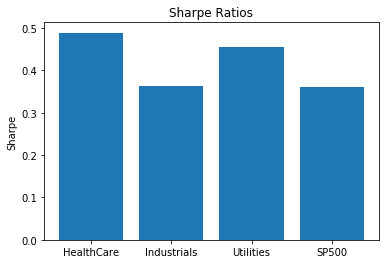

In [22]:
#Plot the sharpe ratios

objects = ('HealthCare', 'Industrials', 'Utilities', 'SP500')
y_pos = np.arange(len(objects))
sharpe = [HealthCare_sharpe,Industrials_sharpe,Utilities_sharpe, SP500_sharpe]

plt.bar(y_pos, sharpe, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Sharpe')
plt.title('Sharpe Ratios')

plt.show()

In [23]:
# Drop nulls on Returns
returns_df.dropna(inplace=True)

#count nulls 
returns_df.isnull().sum()

HealthCare_return     0
Industrials_return    0
Utilities_return      0
SP500_return          0
dtype: int64

In [24]:
#Check correlation

sector_correlation = returns_df.corr()
sector_correlation

,HealthCare_return,Industrials_return,Utilities_return,SP500_return
HealthCare_return,1.000000,0.736826,0.555102,0.808325
Industrials_return,0.736826,1.000000,0.566525,0.903801
Utilities_return,0.555102,0.566525,1.000000,0.646361
SP500_return,0.808325,0.903801,0.646361,1.000000


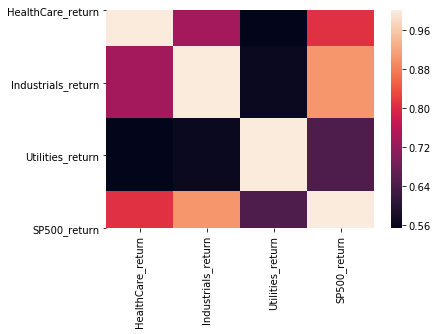

In [25]:
# Heapmap to visualize sector correlation
sns.heatmap(sector_correlation)

In [26]:
#BETA CALCULATION Healthcare Sector and S&P 500

# Calculate covariance of Healthcare vs. S&P 500
health_covariance = returns_df['HealthCare_return'].cov(returns_df['SP500_return'])
health_covariance

# Calculate variance of S&P 500 returns
variance = returns_df['SP500_return'].var()
variance

# Calculate beta of Healthcare Sector
HealthCare_beta = health_covariance / variance
HealthCare_beta

0.7597335213738832

In [27]:
#BETA CALCULATION Industrial Sector and S&P 500

# Calculate covariance of Industrials vs. S&P 500
industrials_covariance = returns_df['Industrials_return'].cov(returns_df['SP500_return'])
industrials_covariance

# Calculate variance of S&P 500 returns
variance = returns_df['SP500_return'].var()
variance

# Calculate beta of Industrial Sector
Industrials_beta = industrials_covariance / variance
Industrials_beta

1.0004255994212163

In [28]:
#BETA CALCULATION Utilities and S&P 500

# Calculate covariance of Utilities vs. S&P 500
utilities_covariance = returns_df['Utilities_return'].cov(returns_df['SP500_return'])
utilities_covariance

# Calculate variance of S&P 500 returns
variance = returns_df['SP500_return'].var()
variance

# Calculate beta of Utilities Sector
Utilities_beta = utilities_covariance / variance
Utilities_beta

0.6454784314962837

A 10,000 investment in the Healthcare Sector would have decreased to 43396.87088288664


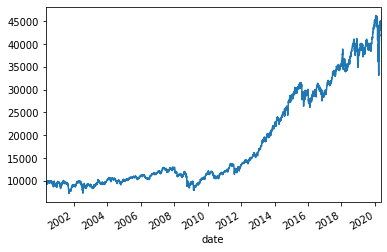

In [29]:
# Plot the monetary returns of HealthCare Sector 
initial_investment = 10000
cumulative_profit_health = initial_investment * cumulative_returns_health
print(f'A 10,000 investment in the Healthcare Sector would have decreased to {cumulative_profit_health[-1]}')
cumulative_profit_health.plot()

A 10,000 investment in the Healthcare Sector would have grown to 30101.175139822586


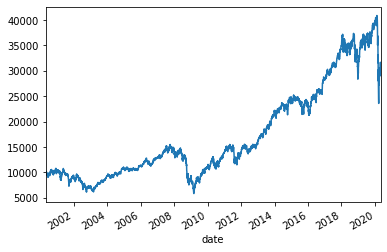

In [30]:
# Plot the monetary returns of Industrial Sector 
initial_investment = 10000
cumulative_profit_industrial = initial_investment * cumulative_returns_industrial
print(f'A 10,000 investment in the Healthcare Sector would have grown to {cumulative_profit_industrial[-1]}')
cumulative_profit_industrial.plot()

A 10,000 investment in the Healthcare Sector would have grown to 40681.12491900893


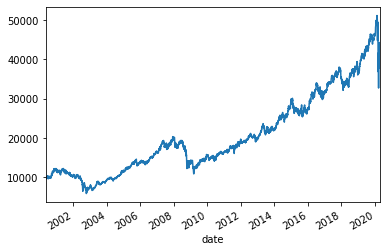

In [31]:
# Plot the monetary returns of Utilities Sector 
initial_investment = 10000
cumulative_profit_utilities = initial_investment * cumulative_returns_utilities
print(f'A 10,000 investment in the Healthcare Sector would have grown to {cumulative_profit_utilities[-1]}')
cumulative_profit_utilities.plot()

In [32]:
#START MONTE CARLO ANALYSIS (HealthCare)

#check concat_df
returns_df.head()

,HealthCare_return,Industrials_return,Utilities_return,SP500_return
date,,,,
2000-05-02,-0.020059,-0.010229,-0.036167,-0.019974
2000-05-03,-0.027853,-0.033333,0.003641,-0.023417
2000-05-04,-0.003106,0.001723,-0.001814,0.007548
2000-05-05,-0.001387,0.017557,0.002179,0.012120
2000-05-08,0.002428,-0.000337,0.006899,-0.007512


In [33]:
# Calculate the mean of daily returns for HealthCare
avg_daily_return_HealthCare = returns_df.mean()['HealthCare_return']
print(f"The average daily return of the HealthCare sector is {avg_daily_return_HealthCare}")


# Calculate the mean of daily returns for Industrials
avg_daily_return_Industrials = returns_df.mean()['Industrials_return']
print(f"The average daily return of the Industrials sector is {avg_daily_return_Industrials}")

# Calculate the mean of daily returns for Utilities
avg_daily_return_Utilities = returns_df.mean()['Utilities_return']
print(f"The average daily return of the Utilities sector is {avg_daily_return_Utilities}")

The average daily return of the HealthCare sector is 0.0003599403921252823
The average daily return of the Industrials sector is 0.0003139952631225437
The average daily return of the Utilities sector is 0.00035585688571524766


In [34]:
#Set up Monte Carlo Simulation for HealthCare

#Set number of simulations

num_simulations = 1000

# Set number of trading days and get last closing price of XLB from DataFrame

num_trading_days = 30
HealthCare_last_price = health_df[1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_HealthCare_df = pd.DataFrame()

In [35]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_HealthCare_prices = [HealthCare_last_price]
    simulated_HealthCare_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_HealthCare_prices[-1] * (1 + np.random.normal(avg_daily_return_HealthCare, HealthCare_std))
        # Append the simulated price to the list
        simulated_HealthCare_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_HealthCare_df[f"Simulation {n+1}"] = pd.Series(simulated_HealthCare_prices)

simulated_prices_HealthCare_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000,...,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000,99.730000
1,101.156312,99.423085,98.479161,100.585460,99.894103,99.372158,100.031437,100.249807,98.744721,99.333640,...,100.297746,99.902747,100.641006,100.059417,100.241471,101.153359,99.605908,99.128438,99.953874,97.942438
2,101.839072,99.976773,98.689355,101.893221,99.305754,101.164445,100.377127,100.192956,98.035928,99.053533,...,99.953070,99.066503,100.006449,99.629343,100.071335,101.881719,99.894440,100.842908,100.028957,99.049884
3,101.485390,101.315744,97.657242,102.534167,98.812478,100.754999,102.157381,102.811427,97.027317,99.275404,...,100.529516,100.296340,100.452257,99.731923,100.803499,102.245012,99.867824,99.287848,99.398394,99.444876
4,100.513438,100.421201,99.599243,104.990265,99.570628,102.118165,102.299984,102.993124,97.797801,98.092239,...,100.925851,102.152423,102.935905,100.142130,102.480976,99.227667,100.210466,99.685625,98.076081,98.975639


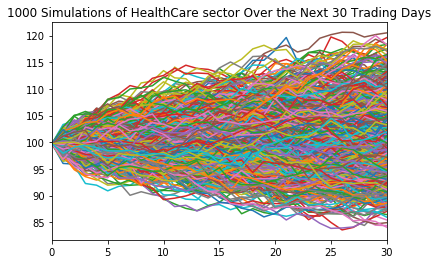

In [36]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of HealthCare sector Over the Next 30 Trading Days"
simulated_prices_HealthCare_df.plot(legend=None, title=plot_title)

In [37]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_HealthCare = simulated_prices_HealthCare_df.iloc[-1, :]
simulated_ending_prices_HealthCare.head()

Simulation 1     98.118186
Simulation 2    104.879736
Simulation 3    103.695297
Simulation 4    103.495576
Simulation 5     97.884091
Name: 30, dtype: float64

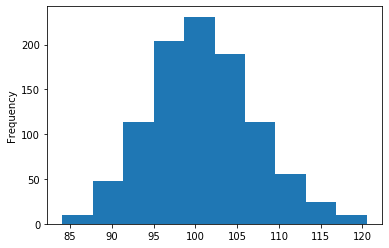

In [38]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_HealthCare.plot(kind='hist')

In [39]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_HealthCare.quantile(q=[0.025, 0.975])
confidence_interval

0.025     89.088249
0.975    114.265772
Name: 30, dtype: float64

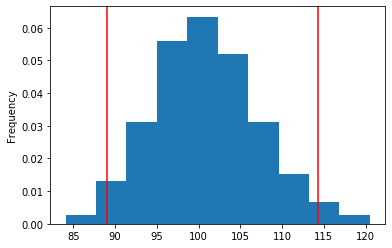

In [40]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_HealthCare.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [41]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - HealthCare_last_price) / HealthCare_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - HealthCare_last_price) / HealthCare_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the HealthCare sector"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in the HealthCare sector over the next 30 trading days will end within in the range of $8932.94 and $11457.51


In [42]:
#Set up Monte Carlo Simulation for Industrials

#Set number of simulations

num_simulations = 1000

# Set number of trading days and get last closing price of XLB from DataFrame

num_trading_days = 30
Industrials_last_price = industrial_df[1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_Industrials_df = pd.DataFrame()

In [43]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_Industrials_prices = [Industrials_last_price]
    simulated_Industrials_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price_i = simulated_Industrials_prices[-1] * (1 + np.random.normal(avg_daily_return_Industrials, Industrials_std))
        # Append the simulated price to the list
        simulated_Industrials_prices.append(simulated_price_i)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_Industrials_df[f"Simulation {n+1}"] = pd.Series(simulated_Industrials_prices)

simulated_prices_Industrials_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000,...,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000,64.210000
1,63.098163,66.046798,64.848915,64.978023,64.364425,64.419765,63.956469,64.036517,65.366287,64.157018,...,62.888946,64.037223,62.460542,64.017971,63.888148,62.940547,63.124556,63.990813,64.423163,63.851130
2,62.983881,66.062159,64.852612,66.604666,63.505880,64.051131,63.502589,65.026502,65.921559,64.119211,...,62.061164,63.921700,61.355287,64.867541,62.692758,62.909907,63.331680,63.748484,65.140609,63.777942
3,63.071037,66.396044,66.343841,66.958386,63.041851,65.046676,62.565226,64.511273,65.981453,63.444868,...,62.955450,63.517112,62.758998,65.931937,61.796596,63.095927,64.019155,63.143532,64.515159,63.114229
4,63.607294,66.905423,66.431239,67.321115,63.222610,63.404609,61.352603,65.198010,65.948215,62.707733,...,64.050980,64.318056,61.796320,66.356002,62.448990,62.603188,62.566682,62.945746,63.948597,63.263178


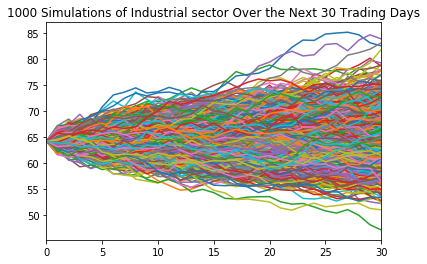

In [44]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of Industrial sector Over the Next 30 Trading Days"
simulated_prices_Industrials_df.plot(legend=None, title=plot_title)

In [45]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_Industrials = simulated_prices_Industrials_df.iloc[-1, :]
simulated_ending_prices_Industrials.head()

Simulation 1    62.531713
Simulation 2    57.834937
Simulation 3    69.039162
Simulation 4    71.121158
Simulation 5    52.241531
Name: 30, dtype: float64

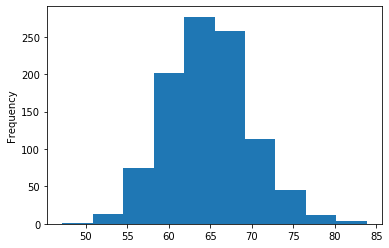

In [46]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_Industrials.plot(kind='hist')

In [47]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_Industrials.quantile(q=[0.025, 0.975])
confidence_interval

0.025    55.066931
0.975    75.034996
Name: 30, dtype: float64

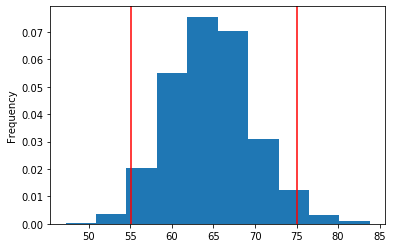

In [48]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_Industrials.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [49]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - Industrials_last_price) / Industrials_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - Industrials_last_price) / Industrials_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the Industrial sector"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in the Industrial sector over the next 30 trading days will end within in the range of $8576.07 and $11685.87


In [50]:
#Set up Monte Carlo Simulation for Utilities

#Set number of simulations

num_simulations = 1000

# Set number of trading days and get last closing price of XLB from DataFrame

num_trading_days = 30
Utilities_last_price = utilities_df[1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_Utilities_df = pd.DataFrame()

In [51]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_Utilities_prices = [Utilities_last_price]
    simulated_Utilities_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price_u = simulated_Utilities_prices[-1] * (1 + np.random.normal(avg_daily_return_Utilities, Utilities_std))
        # Append the simulated price to the list
        simulated_Utilities_prices.append(simulated_price_u)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_Utilities_df[f"Simulation {n+1}"] = pd.Series(simulated_Utilities_prices)

simulated_prices_Utilities_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000,...,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000,57.260000
1,58.187230,56.595744,57.597966,57.179677,56.769272,58.161821,57.614229,55.962858,56.957839,57.602479,...,57.469186,58.677858,57.267574,56.077755,58.664687,57.435670,56.852869,57.477712,57.235125,56.479086
2,59.140571,56.783175,57.984338,58.898744,56.423129,60.294816,57.196633,56.037351,57.095660,57.912551,...,57.555014,59.269115,58.608774,56.218362,58.228952,57.679574,57.013147,58.270231,57.883639,55.758896
3,58.991963,57.663851,58.771811,58.048692,56.778314,60.257588,57.674792,57.860665,57.064211,58.387073,...,57.243337,61.266348,58.890163,56.011521,58.436695,57.336815,57.785333,58.452540,57.904280,54.984157
4,59.856440,58.116295,59.085142,58.303245,55.515243,60.093633,58.509100,58.432677,58.365970,58.350418,...,57.198059,61.529142,59.137139,55.736845,56.535476,57.719506,57.832512,58.209040,57.590532,55.561785


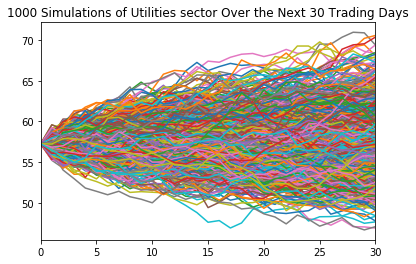

In [52]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of Utilities sector Over the Next 30 Trading Days"
simulated_prices_Utilities_df.plot(legend=None, title=plot_title)

In [53]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_Utilities = simulated_prices_Utilities_df.iloc[-1, :]
simulated_ending_prices_Utilities.head()

Simulation 1    58.391994
Simulation 2    60.585275
Simulation 3    56.018850
Simulation 4    64.352627
Simulation 5    49.835933
Name: 30, dtype: float64

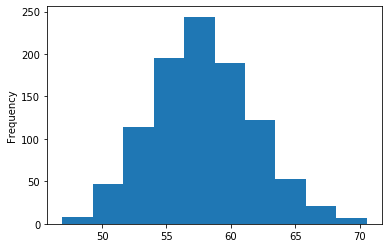

In [54]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_Utilities.plot(kind='hist')

In [55]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_Utilities.quantile(q=[0.025, 0.975])
confidence_interval

0.025    50.476790
0.975    66.193819
Name: 30, dtype: float64

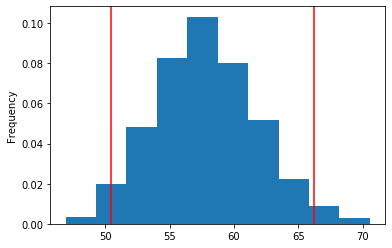

In [56]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_Utilities.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [57]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - Utilities_last_price) / Utilities_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - Utilities_last_price) / Utilities_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the Utilities sector"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in the Utilities sector over the next 30 trading days will end within in the range of $8815.37 and $11560.22
